# Capstone Project: The Battle of Neighborhoods

## Choose a good location for a new student apartment in Berlin with Intelligent Data Analysis Approach.  

## Agenda
### 1. Buisness Problem
### 2. Data Description
### 3. Approach
### 4. Results and Evaluation
### 5. Discussion

### 1. Business Problem

In this case, one of my contractor in the real estate buisiness is considering about investigating on a student apartment project in Berlin. My client hopes that I can make a reasonable predictive analysis on the appropriete spot  of the new apartment based on some specified requirements.
1. The apartment is going to be settled in a safe neighborhood with **low crime rate**.
2. The rental price shall **around the average level in Berlin**.
3. Since the apartment is targeted for students who usually travelled around with public transit, there should better be **groceries and coffee shops** nearby.

### 2. Data Description 

In this section, data that is used are presented in detail. 

We now want to collect all necessary data for the defined problem. 
First I download the real crime data in berlin between 2012 and 2019 frorm kaggle:
>https://www.kaggle.com/danilzyryanov/crime-in-berlin-2012-2019?select=Berlin_crimes.csv

and retrieve the geographical coordinates by Geocoder pacakge for all city parts in berlin:
>https://www.suche-postleitzahl.org/berlin.13f

The rental price in all districts in berlin of  year 2019 can be scraped from webpage:
>https://www.wohnungsboerse.net/mietspiegel-Berlin/2825

The relevant venues information like groceries and coffee shops are explored by FourSquare request.

### 2.1 Data preparation 
The first step is the so-called ETL step to extract, transform and load the underlying dataset. Then a **data exploaration** is carried out to have a intuitive understanding of the dataset. All applied dataset shall be transformed into formats well ajusted for the appliance. 

### 2.2 Import Libraries

In [2]:
#dataframes 
import pandas as pd
import numpy as np
import random 

#handle requests and json files
import json # deal with json files
import requests

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
!pip install folium
import folium 
from bs4 import BeautifulSoup

     |████████████████████████████████| 94 kB 5.9 MB/s  eta 0:00:01


In [3]:
# module to convert an address into latitude and longitude values
!pip install geopy
!pip install geocoder
from geopy.geocoders import Nominatim
import geocoder
#tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
#Library for k-mean algoritm
from sklearn.cluster import KMeans
print('Libraries imported.')

     |████████████████████████████████| 98 kB 9.0 MB/s  eta 0:00:01
Libraries imported.


### 2.3 Retrieve Crime Data in Berlin from 2012 to 2019

In [4]:
crime_df = pd.read_csv('https://raw.githubusercontent.com/xiaodiiii/demo/main/Berlin_crimes.csv',sep=';')
crime_df.head()

,Year,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local
0,2012,Mitte,10111,Tiergarten Süd,70,46,586,194,118,2263,18,328,120,68,16,4,273,26,171,1032
1,2012,Mitte,10112,Regierungsviertel,65,29,474,123,142,3203,10,307,170,37,10,4,380,124,98,870
2,2012,Mitte,10113,Alexanderplatz,242,136,1541,454,304,8988,81,792,822,275,49,27,1538,522,435,3108
3,2012,Mitte,10114,Brunnenstraße Süd,52,25,254,60,66,1916,86,192,396,131,14,5,428,122,213,752
4,2012,Mitte,10221,Moabit West,130,51,629,185,199,2470,94,410,325,161,42,22,516,64,259,1403


Then I want to calculate the average crimes numbers over the 8 years in each district.

In [5]:
crime_dict = {}#generate a dictionary to save crime cases in each year
for year in crime_df['Year'].unique():
    df = crime_df.loc[crime_df['Year']==year]
    df = df.reset_index(drop=True)
    crime_dict[year] = df.iloc[:,4:-1]#only save different sorts of crimes in the dict

In [6]:
from functools import reduce
#the averaged crime cases over 8 years in different locations in berlin
crime_avg = reduce(lambda x, y: pd.DataFrame.add(x, y, fill_value=0), [df for year, df in crime_dict.items()]) // len(crime_dict)
#merge the boroughs/district and postal code together with the crime avg.
avg_crime_df = pd.concat([crime_df[['District', 'Code', 'Location']],crime_avg], axis=1)
#rename some colomns
avg_crime_df.rename(columns={'District':'Borough', 'Code': 'Postal Code'}, inplace=True)
#add total cases in last column
avg_crime_df['Total Cases'] = avg_crime_df.iloc[:, -4:-1].sum(axis=1)
avg_crime_df = avg_crime_df.dropna()
avg_crime_df.head()

,Borough,Postal Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Total Cases
0,Mitte,10111,Tiergarten Süd,71.0,49.0,483.0,131.0,120.0,2526.0,18.0,293.0,236.0,57.0,13.0,4.0,277.0,45.0,175.0,326.0
1,Mitte,10112,Regierungsviertel,56.0,28.0,478.0,104.0,132.0,4349.0,14.0,244.0,313.0,44.0,8.0,2.0,380.0,129.0,95.0,511.0
2,Mitte,10113,Alexanderplatz,181.0,106.0,1541.0,411.0,333.0,10783.0,79.0,716.0,989.0,209.0,42.0,16.0,1223.0,380.0,684.0,1619.0
3,Mitte,10114,Brunnenstraße Süd,36.0,19.0,240.0,52.0,69.0,2208.0,61.0,220.0,417.0,98.0,12.0,5.0,401.0,157.0,94.0,563.0
4,Mitte,10221,Moabit West,90.0,43.0,637.0,176.0,199.0,2612.0,58.0,446.0,383.0,118.0,34.0,14.0,529.0,81.0,417.0,624.0


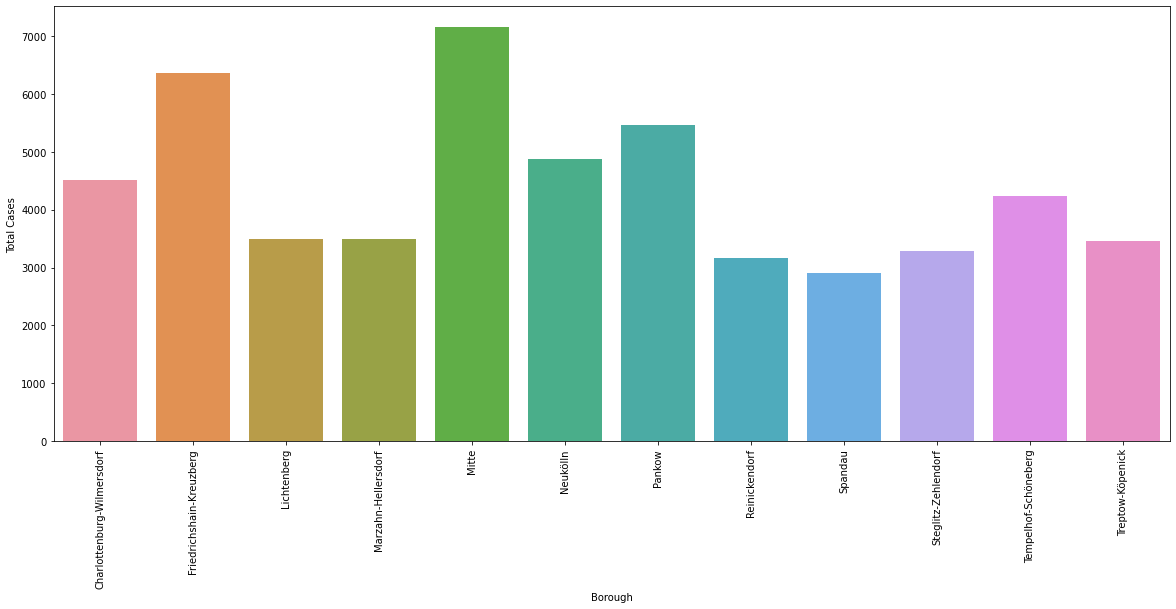

In [88]:
#plot the total crime cases of each borough in berlin.
plt.figure(figsize=(20,8))
plt.xticks(rotation='vertical')
avg_crime_df2 = avg_crime_df.groupby('Borough').sum()
ax = sns.barplot(x=avg_crime_df2.index, y="Total Cases", data=avg_crime_df2)

In [89]:
avg_crime_df2 = avg_crime_df2.drop(['Postal Code'], axis=1)
avg_crime_df2 = avg_crime_df2[['Total Cases']].reset_index()
avg_crime_df2

,Borough,Total Cases
0,Charlottenburg-Wilmersdorf,4513.0
1,Friedrichshain-Kreuzberg,6357.0
2,Lichtenberg,3501.0
3,Marzahn-Hellersdorf,3487.0
4,Mitte,7153.0
5,Neukölln,4876.0
6,Pankow,5461.0
7,Reinickendorf,3166.0
8,Spandau,2905.0
9,Steglitz-Zehlendorf,3289.0


### 2.4 All boroughs in Berlin 

the entire berlin borough and postal code information is found available in the following website, however some transformation works are necessary.

In [189]:
import itertools
berlin_psc_df = pd.read_csv('https://raw.githubusercontent.com/xiaodiiii/demo/main/ZuordnungderBezirkezuPostleitzahlen.csv')
berlin_psc_df.rename(columns={'Bezirk':'Borough', 'Postleitzahlen':'PostalCode'}, inplace=True)
from itertools import chain
# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(';')))

# calculate lengths of splits
lens = berlin_psc_df['PostalCode'].str.split(';').map(len)
# create new dataframe, repeating or chaining as appropriate
berlin_poc_df = pd.DataFrame({'Borough': np.repeat(berlin_psc_df['Borough'], lens),
                    'PostalCode': chainer(berlin_psc_df['PostalCode'])})
berlin_poc_df.reset_index(drop=True)

,Borough,PostalCode
0,Mitte,10115
1,Mitte,10117
2,Mitte,10119
3,Mitte,10178
4,Mitte,10179
...,...,...
249,Reinickendorf,13507
250,Reinickendorf,13509
251,Reinickendorf,13599
252,Reinickendorf,13629


### 2.5 Rental Price in Berlin 

This information is scrabed from the following webpage: https://www.statista.com/statistics/800580/rent-expenditure-apartments-berlin-germany-by-district/

In [191]:
url = 'https://www.statista.com/statistics/800580/rent-expenditure-apartments-berlin-germany-by-district/'
berlin_price_df = pd.read_html(url, header=0)[0]
#modify header names
berlin_price_df.rename(columns={'Unnamed: 0':'Borough', 'Average monthly rent in euro per sq meter':'Rental Price per Qm'}, inplace=True)
berlin_price_df.dropna(inplace = True)
berlin_price_df

,Borough,Rental Price per Qm
0,Mitte,13.42
1,Friedrichshain-Kreuzberg,13.00
2,Charlottenburg-Wilmersdorf,12.65
3,Pankow,10.94
4,Steglitz-Zehlendorf,10.67
5,Tempelhof-Schöneberg,10.52
6,Berlin total,10.44
7,Neukölln,10.06
8,Treptow-Köpenick,9.92
9,Lichtenberg,9.26


The next step is to merge relevant columns together into one single dataframe.

In [192]:
print('Number of different post codes in berlin in crimes dataset is ', len(avg_crime_df))
print('Number of different post codes in berlin in post codes dataset is ', len(berlin_poc_df))

Number of different post codes in berlin in crimes dataset is  150
Number of different post codes in berlin in post codes dataset is  254


Unfortunately due to the data confidential issue there are two boroughs are missing in their rental prices. And the Postal codes in crimes data are somehow **wrong** as below. So we simly use the post codes data in post code dataset.
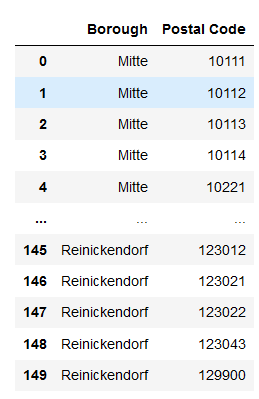

In [193]:
berlin_df1 = pd.merge(avg_crime_df2, berlin_price_df, left_on = 'Borough', right_on = 'Borough')
berlin_df2 = pd.merge(berlin_df1, berlin_poc_df, left_on = 'Borough', right_on = 'Borough')
berlin_df2.groupby(['Borough']).groups
berlin_df3 = berlin_df2.dropna()
berlin_df3.head()

,Borough,Total Cases,Rental Price per Qm,PostalCode
0,Charlottenburg-Wilmersdorf,4513.0,12.65,10553
1,Charlottenburg-Wilmersdorf,4513.0,12.65,10585
2,Charlottenburg-Wilmersdorf,4513.0,12.65,10587
3,Charlottenburg-Wilmersdorf,4513.0,12.65,10589
4,Charlottenburg-Wilmersdorf,4513.0,12.65,10623


as the number of crimes cases for each postal code areas are not correctly given in the raw data, **divided the total cases evenly** to each relevant area.

In [194]:
poc_num = pd.DataFrame(berlin_df3.groupby(['Borough'])['Total Cases'].count()).reset_index()
berlin_df = pd.merge(berlin_df3, poc_num, left_on = 'Borough', right_on = 'Borough')
#iterate to calculate mean cases for each postal code areas
for i in range(len(berlin_df)):
    berlin_df.loc[i,'Total Cases_x'] = berlin_df.loc[i,'Total Cases_x'] / berlin_df.loc[i,'Total Cases_y']

In [195]:
berlin_df.rename(columns={'Total Cases_x': 'Crime Cases'}, inplace=True)
berlin_df = berlin_df[['Borough', 'PostalCode', 'Crime Cases', 'Rental Price per Qm']]
berlin_df.head()

,Borough,PostalCode,Crime Cases,Rental Price per Qm
0,Charlottenburg-Wilmersdorf,10553,128.942857,12.65
1,Charlottenburg-Wilmersdorf,10585,128.942857,12.65
2,Charlottenburg-Wilmersdorf,10587,128.942857,12.65
3,Charlottenburg-Wilmersdorf,10589,128.942857,12.65
4,Charlottenburg-Wilmersdorf,10623,128.942857,12.65


### 2.6 Geocoder find Coordinates of each Borough in Berlin

In [196]:
#define a function to return coordinates
def get_coordinates(postalcode, borough):
    lat_lng_coords = None
    while lat_lng_coords is None:
        g = geocoder.arcgis('{}, {}'.format(postalcode, borough))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    return latitude, longitude
#find lat and lng for each postal code in berlin dataframe
for i in range(0, len(berlin_df)):
    postalcode = berlin_df.loc[i,'PostalCode']
    borough = berlin_df.loc[i,'Borough']
    lat, lon = get_coordinates(postalcode, borough)
    berlin_df.loc[berlin_df.index[i], 'Latitude'] = lat #allocate latitude to new column Latitude
    berlin_df.loc[berlin_df.index[i], 'Longitude'] = lon #allocate longitude to new column longitude

    
berlin_df.head()

,Borough,PostalCode,Crime Cases,Rental Price per Qm,Latitude,Longitude
0,Charlottenburg-Wilmersdorf,10553,128.942857,12.65,52.499620,13.323160
1,Charlottenburg-Wilmersdorf,10585,128.942857,12.65,52.514816,13.304804
2,Charlottenburg-Wilmersdorf,10587,128.942857,12.65,52.499620,13.323160
3,Charlottenburg-Wilmersdorf,10589,128.942857,12.65,52.499620,13.323160
4,Charlottenburg-Wilmersdorf,10623,128.942857,12.65,52.499620,13.323160


### 2.7 Get connnect to FourSquare to explore the  boroughs' neighborhoods

In [198]:
CLIENT_ID = 'UJ50JPVA2FQOF5GD0YRACXEV4UMDA0N1EANKDITSRAQKJTIH'
CLIENT_SECRET = 'B0OD3WNABMHYB5JZRTOIGQA02GGT3QQR2PJPHFYS2EUQMS4H'
VERSION = '20180605'
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 750 
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UJ50JPVA2FQOF5GD0YRACXEV4UMDA0N1EANKDITSRAQKJTIH
CLIENT_SECRET:B0OD3WNABMHYB5JZRTOIGQA02GGT3QQR2PJPHFYS2EUQMS4H


Use this function to retrive all the venues around the location provided with its latitude and longitude and a radius.

In [202]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    """
    get nearby venues for the given location names and their geographical coordinates within a radius of 500 meters.
    """
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [203]:
#call the previous function to get a dataframe with nearby venues in berlin
berlin_venues = getNearbyVenues(names=berlin_df['Borough'],
                                   latitudes=berlin_df['Latitude'],
                                   longitudes=berlin_df['Longitude']
                                   )

In [204]:
berlin_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Charlottenburg-Wilmersdorf,52.49962,13.32316,Mövenpick Weinkeller,52.499556,13.320365,Wine Shop
1,Charlottenburg-Wilmersdorf,52.49962,13.32316,BERLINRODEO interior concepts GmbH,52.501163,13.325814,Furniture / Home Store
2,Charlottenburg-Wilmersdorf,52.49962,13.32316,Sweet2go,52.497776,13.322638,Dessert Shop
3,Charlottenburg-Wilmersdorf,52.49962,13.32316,Piccola Taormina,52.501231,13.324884,Italian Restaurant
4,Charlottenburg-Wilmersdorf,52.49962,13.32316,Hamlet,52.497872,13.323996,Italian Restaurant


### 3. Approach

In this section, we are going to discuss on the applied analysis methods to help the client find the best location for the student apartment. Now with two dataframes: **berlin_df** and **berlin_venues** by hand. We can use machine learning algorithm, in this case, *k-means clustering* to solve the issue. The first dataset **berlin_df** with crimes data and rental price data can help in determine the safe area/spot for the apartment with a generally lower rental price land. The second one **berlin_venues** with all detected venues nearby is benificial in find the place which match the client's preferences including in the nearby of coffee shops and groceries.

Before we go further into the analysis, let's take a deeper look into the dataset.

In [210]:
# get a description of the stats of crime cases 
berlin_df.describe()['Crime Cases'].to_frame()

,Crime Cases
count,209.000000
mean,205.066986
std,78.435514
min,128.942857
25%,131.560000
50%,216.500000
75%,264.925926
max,397.312500


In [211]:
# get a description of the stats of rental price  
berlin_df.describe()['Rental Price per Qm'].to_frame()

,Rental Price per Qm
count,209.000000
mean,11.332632
std,1.355055
min,9.260000
25%,10.520000
50%,10.670000
75%,12.650000
max,13.420000


#### 3.1 Find boroughs with lower crimes 

first lets find boroughs in berlin with an average crime cases less than the **mean level**, and plot in hists

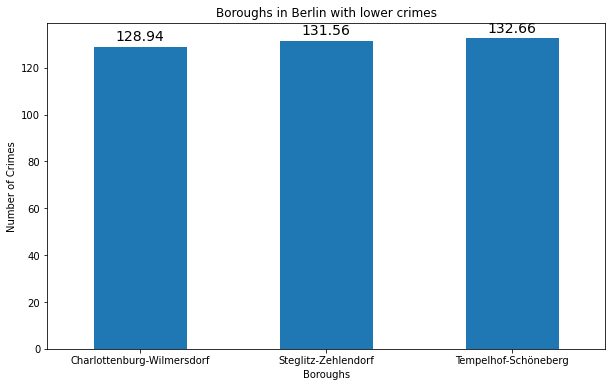

In [253]:
#group the boroughs with low crime cases.
berlin_lowC = berlin_lowC.loc[berlin_lowC['Crime Cases'] <= berlin_df['Crime Cases'].mean()]
lowc_df = berlin_lowC.groupby('Borough')['Crime Cases'].mean()
ax = lowc_df.plot(kind='bar', figsize=(10, 6), rot=0)
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Boroughs')
ax.set_title('Boroughs in Berlin with lower crimes')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )
plt.show()

For a comparison we also determine the boroughs in berlin with higher crimes. 

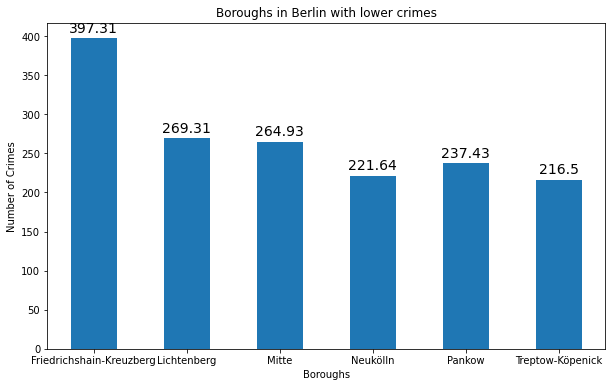

In [254]:
berlin_highC = berlin_df.loc[berlin_df['Crime Cases'] > berlin_df['Crime Cases'].mean()]
highc_df = berlin_highC.groupby('Borough')['Crime Cases'].mean()
ax = highc_df.plot(kind='bar', figsize=(10, 6), rot=0)
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Boroughs')
ax.set_title('Boroughs in Berlin with lower crimes')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )
plt.show()

Based on the exploration, three Neighborhoods are selected as safer areas for the apartment: **Charlottenburg-Wilmersdorf**, **Steglitz-Zehlendorf** and **Tempelhof-Schöneberg**. Now let's see if those neighborhoods provide enough venues amount!

In [261]:
berlin_venues.groupby('Neighborhood')['Venue'].count().to_frame()

,Venue
Neighborhood,
Charlottenburg-Wilmersdorf,1684
Friedrichshain-Kreuzberg,651
Lichtenberg,282
Mitte,871
Neukölln,842
Pankow,505
Steglitz-Zehlendorf,416
Tempelhof-Schöneberg,690
Treptow-Köpenick,68


Great! Those three neighborhoods have lots of venues available, it's highly possible for us to finally determine a good location for the apartment.

Next step is to find boroughs with lower rental price. 

#### 3.2 Find Boroughs with lower rental price 

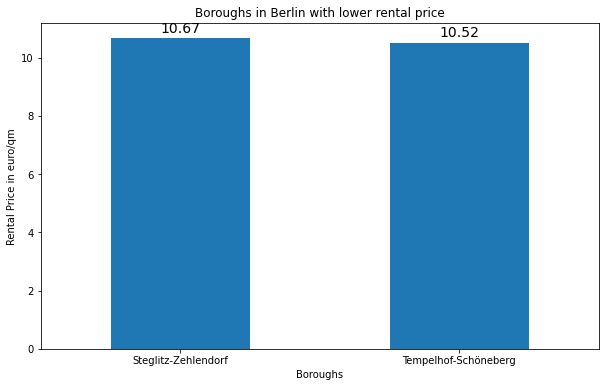

In [288]:
berlin_lowR = berlin_lowC.loc[berlin_lowC['Rental Price per Qm'] <= berlin_df['Rental Price per Qm'].mean()]
lowr_df = berlin_lowR.groupby('Borough')['Rental Price per Qm'].mean()
ax = lowr_df.plot(kind='bar', figsize=(10, 6), rot=0)
ax.set_ylabel('Rental Price in euro/qm')
ax.set_xlabel('Boroughs')
ax.set_title('Boroughs in Berlin with lower rental price')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )
plt.show()

OK, now we have narrowed the boroughs to **Steglitz-Zehlendorf** and **Tempelhof-Schöneberg**. I want to use a map plot to show all venues in these two boroughs in berlin. First get geo coordinates of berlin.

In [289]:
#a preview of the selected dataset of two boroughs
berlin_lowR = berlin_lowR.reset_index(drop=True)
berlin_lowR.head()

,Borough,PostalCode,Crime Cases,Rental Price per Qm,Latitude,Longitude
0,Tempelhof-Schöneberg,12107,132.65625,10.52,52.469076,13.373397
1,Tempelhof-Schöneberg,12157,132.65625,10.52,52.462649,13.343210
2,Tempelhof-Schöneberg,10777,132.65625,10.52,52.497465,13.345170
3,Tempelhof-Schöneberg,12161,132.65625,10.52,52.467259,13.337224
4,Tempelhof-Schöneberg,12163,132.65625,10.52,52.469076,13.373397


In [344]:
berlin_lowR_venues = berlin_venues[(berlin_venues['Neighborhood'].str.contains('Steglitz-Zehlendorf')== True) | (berlin_venues['Neighborhood'].str.contains('Tempelhof-Schöneberg')== True)]
berlin_lowR_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4835,Steglitz-Zehlendorf,52.459016,13.348661,Planetarium am Insulaner,52.457514,13.349227,Planetarium
4836,Steglitz-Zehlendorf,52.459016,13.348661,Insulaner,52.457631,13.352401,Park
4837,Steglitz-Zehlendorf,52.459016,13.348661,Sommerbad am Insulaner,52.456199,13.351579,Pool
4838,Steglitz-Zehlendorf,52.459016,13.348661,Minigolf am Insulaner,52.458426,13.351243,Mini Golf
4839,Steglitz-Zehlendorf,52.459016,13.348661,H Insulaner,52.458961,13.344514,Bus Stop


In [278]:
#find coordinates to berlin
address = 'Berlin, Germany'
geolocator = Nominatim(user_agent="berlin_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


In [291]:
#generate a map to show all boroughs in berlin
berlin_map = folium.Map(location=[latitude, longitude], zoom_start=10)

#add markers of all boroughs to the map 
for lat, lng, borough in zip(
    berlin_df['Latitude'],
    berlin_df['Longitude'],
    berlin_df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lng], radius=4, color='steelblue', fill='True',fill_color='#3186cc',
        fill_opacity=0.7,parse_html=False).add_to(berlin_map)

#add markers of 2 selected boroughs to the map 
for lat, lng, borough in zip(
    berlin_lowR['Latitude'],
    berlin_lowR['Longitude'],
    berlin_lowR['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lng], radius=4, color='green', fill='True',fill_color='green',
        fill_opacity=0.7,parse_html=False).add_to(berlin_map)

berlin_map



#### 3.3 According to the preferences of nearby venues, find all venues that of interest

In [345]:
#venues of interest/preferences
pref_venues = berlin_lowR_venues[(berlin_lowR_venues['Venue Category'].str.contains('Café')==True) | (berlin_lowR_venues['Venue Category'].str.contains('Grocery')==True)]
#define these two sorts of venues to create a map to visualize them all. 
berlin_venueGroc = berlin_lowR_venues[berlin_lowR_venues['Venue Category'].str.match('Grocery')]
berlin_venueCoff = berlin_lowR_venues[berlin_lowR_venues['Venue Category'].str.match('Café')]

#define the map 
berlin_map2 = folium.Map(location=[latitude, longitude], zoom_start=10)
incidents = folium.map.FeatureGroup()

for lat, lng in zip(berlin_venueGroc["Venue Latitude"], berlin_venueGroc["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3,
            color='orange'
        )
    )   

for lat, lng, in zip(berlin_venueCoff["Venue Latitude"], berlin_venueCoff["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3,
            color='red'
        )
    )
berlin_map2.add_child(incidents)    
berlin_map2

As shown in both map1 and map2 ,there are plenty of good choices for the client to find a place for the student apartment, in the next step, I want to use kmeans clustering to cluster those venues in all boroughs.

### 3.4 K-Means Clustering


we do the analysis in following steps:
1. One hot encoding of the venues
2. generate a k-means cluster, set up k values
3. Run clustering of the venues
4. allocate lables to dataframe and merge dataframe together

In [349]:
# one hot encoding all venues
berlin_venues_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")
berlin_venues_onehot['Neighborhood'] = berlin_venues['Neighborhood'] 
berlin_venues_onehot = berlin_venues_onehot[[berlin_venues_onehot.columns[-1]] + list(berlin_venues_onehot.columns[:-1])]
#groub by neighborhood
berlin_venues_grouped = berlin_venues_onehot.groupby('Neighborhood').mean().reset_index()
berlin_venues_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vietnamese Restaurant,Volleyball Court,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,Charlottenburg-Wilmersdorf,0.000000,0.0,0.0,0.000000,0.0,0.016627,0.001188,0.000000,0.000000,...,0.039786,0.000000,0.000594,0.000000,0.000000,0.000000,0.017221,0.001188,0.00000,0.000000
1,Friedrichshain-Kreuzberg,0.001536,0.0,0.0,0.004608,0.0,0.000000,0.019969,0.003072,0.000000,...,0.019969,0.000000,0.000000,0.000000,0.000000,0.004608,0.004608,0.000000,0.00768,0.001536
2,Lichtenberg,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.003546,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,Mitte,0.000000,0.0,0.0,0.000000,0.0,0.001148,0.016073,0.004592,0.002296,...,0.006889,0.001148,0.000000,0.000000,0.000000,0.006889,0.001148,0.000000,0.00000,0.000000
4,Neukölln,0.000000,0.0,0.0,0.005938,0.0,0.000000,0.014252,0.000000,0.000000,...,0.017815,0.000000,0.000000,0.004751,0.001188,0.009501,0.004751,0.000000,0.00000,0.001188


In [350]:
#generate a k-means cluster
kclusters = 7
#ignore neiborhood column
berlin_venues_grouped_clustering = berlin_venues_grouped.drop(['Neighborhood'], axis=1)
#run the clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_venues_grouped_clustering)

In [351]:
berlin_venues_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
#merge berlin_df and berlin clustered df together for plotting
berlin_df_all = berlin_df
berlin_df_all.rename(columns={'Borough':'Neighborhood'}, inplace = True)
berlin_df_all = berlin_df_all.join(berlin_venues_grouped.set_index('Neighborhood'), on='Neighborhood')
berlin_df_all.head()

,Neighborhood,PostalCode,Crime Cases,Rental Price per Qm,Latitude,Longitude,Cluster Labels,ATM,Accessories Store,Adult Boutique,...,Vietnamese Restaurant,Volleyball Court,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
45,Friedrichshain-Kreuzberg,10967,397.3125,13.0,52.487903,13.414571,0,0.001536,0.0,0.0,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536
43,Friedrichshain-Kreuzberg,10963,397.3125,13.0,52.505912,13.375304,0,0.001536,0.0,0.0,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536
42,Friedrichshain-Kreuzberg,10961,397.3125,13.0,52.492123,13.399115,0,0.001536,0.0,0.0,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536
35,Friedrichshain-Kreuzberg,10179,397.3125,13.0,52.512798,13.423496,0,0.001536,0.0,0.0,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536
36,Friedrichshain-Kreuzberg,10243,397.3125,13.0,52.518995,13.427585,0,0.001536,0.0,0.0,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536


Visualize the clustered venues with folium map.

In [352]:
map_berlin3 = folium.Map(location=[latitude, longitude], zoom_start=11)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_df_all['Latitude'], berlin_df_all['Longitude'], berlin_df_all['Neighborhood'], berlin_df_all['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_berlin3)

       
map_berlin3

### 3.5 Now examine each cluster to find the most suited boroughs and neighborhoods based n client's preferences

In [361]:
#cluster 1
berlin_df_all.loc[berlin_df_all['Cluster Labels'] == 0, berlin_df_all.columns[[0] + list(range(5, berlin_df_all.shape[1]))]].head()

,Neighborhood,Longitude,Cluster Labels,ATM,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volleyball Court,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
45,Friedrichshain-Kreuzberg,13.414571,0,0.001536,0.0,0.0,0.004608,0.0,0.0,0.019969,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536
43,Friedrichshain-Kreuzberg,13.375304,0,0.001536,0.0,0.0,0.004608,0.0,0.0,0.019969,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536
42,Friedrichshain-Kreuzberg,13.399115,0,0.001536,0.0,0.0,0.004608,0.0,0.0,0.019969,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536
35,Friedrichshain-Kreuzberg,13.423496,0,0.001536,0.0,0.0,0.004608,0.0,0.0,0.019969,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536
36,Friedrichshain-Kreuzberg,13.427585,0,0.001536,0.0,0.0,0.004608,0.0,0.0,0.019969,...,0.019969,0.0,0.0,0.0,0.0,0.004608,0.004608,0.0,0.00768,0.001536


In [362]:
#cluster 2
berlin_df_all.loc[berlin_df_all['Cluster Labels'] == 1, berlin_df_all.columns[[0] + list(range(5, berlin_df_all.shape[1]))]].head()

,Neighborhood,Longitude,Cluster Labels,ATM,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volleyball Court,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
197,Treptow-Köpenick,13.583250,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,Treptow-Köpenick,13.609500,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,Treptow-Köpenick,13.678983,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,Treptow-Köpenick,13.583250,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,Treptow-Köpenick,13.583250,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [363]:
#cluster 3
berlin_df_all.loc[berlin_df_all['Cluster Labels'] == 2, berlin_df_all.columns[[0] + list(range(5, berlin_df_all.shape[1]))]].head()

,Neighborhood,Longitude,Cluster Labels,ATM,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volleyball Court,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
124,Pankow,13.449050,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00198,0.0
116,Pankow,13.402480,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00198,0.0
126,Pankow,13.429591,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00198,0.0
134,Pankow,13.421843,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00198,0.0
128,Pankow,13.428701,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00198,0.0


In [369]:
#cluster 4
berlin_df_all.loc[berlin_df_all['Cluster Labels'] == 3, berlin_df_all.columns[[0] + list(range(5, berlin_df_all.shape[1]))]].head()

,Neighborhood,Longitude,Cluster Labels,ATM,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volleyball Court,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
147,Steglitz-Zehlendorf,13.351344,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009615,0.0,0.0,0.0,0.0,0.004808,0.0,0.0,0.014423,0.0
156,Steglitz-Zehlendorf,13.222906,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009615,0.0,0.0,0.0,0.0,0.004808,0.0,0.0,0.014423,0.0
158,Steglitz-Zehlendorf,13.311042,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009615,0.0,0.0,0.0,0.0,0.004808,0.0,0.0,0.014423,0.0
137,Steglitz-Zehlendorf,13.333121,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009615,0.0,0.0,0.0,0.0,0.004808,0.0,0.0,0.014423,0.0
154,Steglitz-Zehlendorf,13.276418,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009615,0.0,0.0,0.0,0.0,0.004808,0.0,0.0,0.014423,0.0


In [365]:
#cluster 5
berlin_df_all.loc[berlin_df_all['Cluster Labels'] == 4, berlin_df_all.columns[[0] + list(range(5, berlin_df_all.shape[1]))]].head()

,Neighborhood,Longitude,Cluster Labels,ATM,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volleyball Court,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
60,Lichtenberg,13.501063,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,Lichtenberg,13.480870,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,Lichtenberg,13.480870,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,Lichtenberg,13.472865,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,Lichtenberg,13.476200,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [366]:
#cluster 6
berlin_df_all.loc[berlin_df_all['Cluster Labels'] == 5, berlin_df_all.columns[[0] + list(range(5, berlin_df_all.shape[1]))]].head()

,Neighborhood,Longitude,Cluster Labels,ATM,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volleyball Court,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
3,Charlottenburg-Wilmersdorf,13.323160,5,0.0,0.0,0.0,0.0,0.0,0.016627,0.001188,...,0.039786,0.0,0.000594,0.0,0.0,0.0,0.017221,0.001188,0.0,0.0
4,Charlottenburg-Wilmersdorf,13.323160,5,0.0,0.0,0.0,0.0,0.0,0.016627,0.001188,...,0.039786,0.0,0.000594,0.0,0.0,0.0,0.017221,0.001188,0.0,0.0
5,Charlottenburg-Wilmersdorf,13.323160,5,0.0,0.0,0.0,0.0,0.0,0.016627,0.001188,...,0.039786,0.0,0.000594,0.0,0.0,0.0,0.017221,0.001188,0.0,0.0
6,Charlottenburg-Wilmersdorf,13.306120,5,0.0,0.0,0.0,0.0,0.0,0.016627,0.001188,...,0.039786,0.0,0.000594,0.0,0.0,0.0,0.017221,0.001188,0.0,0.0
7,Charlottenburg-Wilmersdorf,13.307811,5,0.0,0.0,0.0,0.0,0.0,0.016627,0.001188,...,0.039786,0.0,0.000594,0.0,0.0,0.0,0.017221,0.001188,0.0,0.0


In [367]:
#cluster 7
berlin_df_all.loc[berlin_df_all['Cluster Labels'] == 6, berlin_df_all.columns[[0] + list(range(5, berlin_df_all.shape[1]))]].head()

,Neighborhood,Longitude,Cluster Labels,ATM,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volleyball Court,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
102,Neukölln,13.422534,6,0.0,0.0,0.0,0.005938,0.0,0.0,0.014252,...,0.017815,0.0,0.0,0.004751,0.001188,0.009501,0.004751,0.0,0.0,0.001188
98,Neukölln,13.432915,6,0.0,0.0,0.0,0.005938,0.0,0.0,0.014252,...,0.017815,0.0,0.0,0.004751,0.001188,0.009501,0.004751,0.0,0.0,0.001188
105,Neukölln,13.430082,6,0.0,0.0,0.0,0.005938,0.0,0.0,0.014252,...,0.017815,0.0,0.0,0.004751,0.001188,0.009501,0.004751,0.0,0.0,0.001188
100,Neukölln,13.467916,6,0.0,0.0,0.0,0.005938,0.0,0.0,0.014252,...,0.017815,0.0,0.0,0.004751,0.001188,0.009501,0.004751,0.0,0.0,0.001188
103,Neukölln,13.435410,6,0.0,0.0,0.0,0.005938,0.0,0.0,0.014252,...,0.017815,0.0,0.0,0.004751,0.001188,0.009501,0.004751,0.0,0.0,0.001188


### 4. Results and Evaluation 

In this section, the analysis results are will be discussed and we can also decide if this k-means algorithm provide a proper solution for the client to determin the new student apartment location.


We first develop an explorative analysis with dataset **berlin_df** which contains the rental price of boroughs and crime cases in berlin and it's not hard to find out two specific boroughs that meet the requirements: **Steglitz-Zehlendorf** and **Tempelhof-Schöneberg**. Then we do this k-means clustering over venues in all boroughs in berlin. In overall 7 clusters, we are delight to find out that cluster1 in **red** and cluster4 in **blue** match with the previous analysis and thus we can determine the potential locations in Neighborhoods within these two clusters.

In [379]:
res = berlin_df_all[headers]
cluster4_df=res[res["Cluster Labels"] == 3].reset_index(drop=True)
cluster4_df.head()

,Neighborhood,PostalCode,Longitude,Latitude,Cluster Labels,Crime Cases,Rental Price per Qm
0,Steglitz-Zehlendorf,12249,13.351344,52.425315,3,131.56,10.67
1,Steglitz-Zehlendorf,14193,13.222906,52.458019,3,131.56,10.67
2,Steglitz-Zehlendorf,14197,13.311042,52.467170,3,131.56,10.67
3,Steglitz-Zehlendorf,12161,13.333121,52.466244,3,131.56,10.67
4,Steglitz-Zehlendorf,14167,13.276418,52.422015,3,131.56,10.67


In [385]:
cluster1_df=res[res["Cluster Labels"] == 0].groupby('Crime Cases').mean()
cluster1_df.reset_index()

,Crime Cases,Longitude,Latitude,Cluster Labels,Rental Price per Qm
0,132.656250,13.364410,52.475757,0,10.52
1,264.925926,13.406965,52.525837,0,13.42
2,397.312500,13.421493,52.503541,0,13.00


One can interpret that cluster 1 still contains boroughs like Mitte, which stands ahigh crime cases and rental price. Under this consideration, Neighborhoods in **Steglitz-Zehlendorf** remains the best choice.

### 5. Conclustion

In this case study, I have explored up to three datasets in berlin to find a solution for a client, who whish to find a good location for a new student apartment. The requirements include the safety in surrounding areas and the low rental price. Additionally, the client also want the apartment to be close to venues like coffee shops and groceries, both are often considered by students. After a thorough analysis over the dataset, we have determine the most likely boroughs and narrow the choices down to 2. Then we go through a k-means clustering algorithm to clustered the venues in berlin. Based on this result, one can eventually select out the suited neighborhood in this case. Though the entire analysis is still humble and not taking all possible factors into consideration like the landprice, the distance to the schools and public transits, it is still a good example of applying data science to solve real problems.